# Fixed a major bug

I have changed how states are extracted in SimOOS and Alg1. This might lead to a very different performance.

I have tuned SimOOS and Algorithm1 again after fixing bug.

This is supposed to be final evaluation.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
from src import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation_feat_importance.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,parents,has_nurs,form,children,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,3,5,4,4,3
12953,3,5,4,4,1
12955,3,5,4,4,3
12956,3,5,4,4,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [14]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


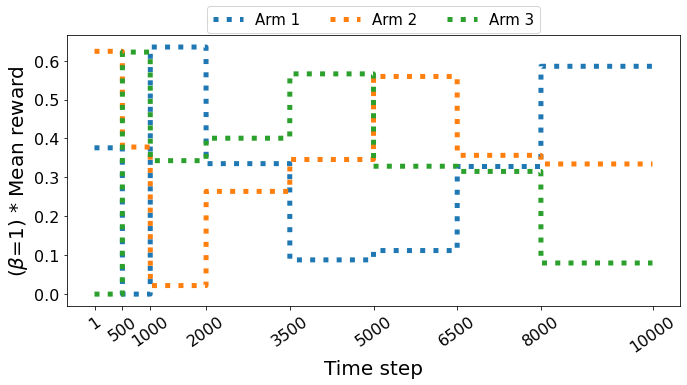

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [16]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [17]:
cost_means_range = [0.01, 0.05]

In [18]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [19]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [20]:
interval_means

[array([0.0249816 , 0.04802857, 0.03927976, 0.03394634, 0.01624075]),
 array([0.01623978, 0.01232334, 0.04464705, 0.0340446 , 0.0383229 ]),
 array([0.01082338, 0.04879639, 0.04329771, 0.01849356, 0.017273  ]),
 array([0.01733618, 0.02216969, 0.03099026, 0.0272778 , 0.02164917]),
 array([0.03447412, 0.01557975, 0.02168579, 0.02465447, 0.0282428 ])]

In [21]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [22]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

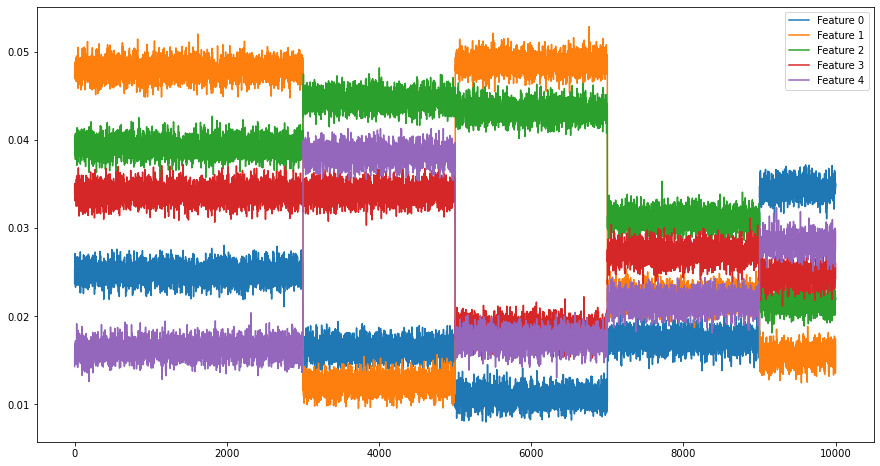

In [23]:
plot_costs(get_costs(), new_contexts.shape[0])

In [24]:
costs_obj = get_costs()

In [25]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [26]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [27]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [28]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

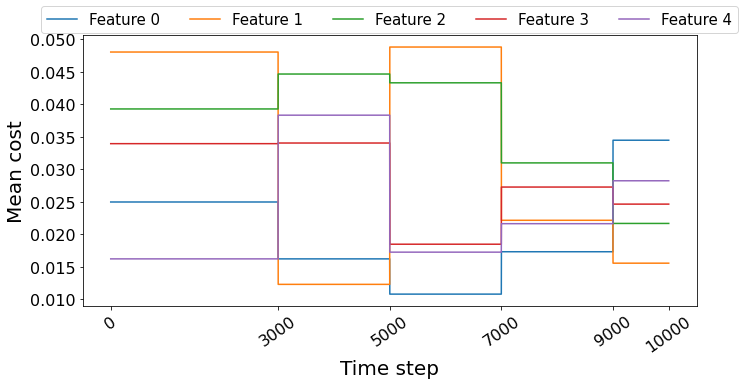

In [29]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [30]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.1700929951305659
Min expected gain for arm 2: -0.14741175322662411
Min expected gain for arm 3: -0.16805707788587704


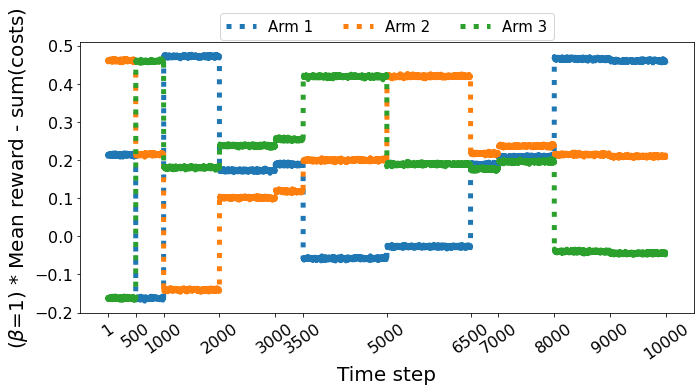

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Testing on non-stationary data

In [32]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [33]:
np.random.seed(42)

In [34]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random, reward_random, cost_random, _ = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_random[i, :] = gain_random
    rewards_random[i, :] = reward_random
    costs_random[i, :] = cost_random
    
gain_random = np.mean(gains_random, axis=0)
reward_random = np.mean(rewards_random, axis=0)
cost_random = np.mean(costs_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3349.0
	Total reward: 3349.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3357.0
	Total reward: 3357.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3350.0
	Total reward: 3350.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3223.0
	Total reward: 3223.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3348.0
	Total reward: 3348.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3325.4


In [35]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy, reward_egreedy, cost_egreedy, _ = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_egreedy[i, :] = gain_egreedy
    rewards_egreedy[i, :] = reward_egreedy
    costs_egreedy[i, :] = cost_egreedy
    
gain_egreedy = np.mean(gains_egreedy, axis=0)
reward_egreedy = np.mean(rewards_egreedy, axis=0)
cost_egreedy = np.mean(costs_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 2810.0
	Total reward: 2810.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3809.0
	Total reward: 3809.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3310.0
	Total reward: 3310.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 4422.0
	Total reward: 4422.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 4291.0
	Total reward: 4291.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3728.4


In [36]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb, reward_ucb, cost_ucb, _ = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_ucb[i, :] = gain_ucb
    rewards_ucb[i, :] = reward_ucb
    costs_ucb[i, :] = cost_ucb

gain_ucb = np.mean(gains_ucb, axis=0)
reward_ucb = np.mean(rewards_ucb, axis=0)
cost_ucb = np.mean(costs_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5177.0


In [37]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb, reward_linucb, cost_linucb, _ = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_linucb[i, :] = gain_linucb
    rewards_linucb[i, :] = reward_linucb
    costs_linucb[i, :] = cost_linucb

gain_linucb = np.mean(gains_linucb, axis=0)
reward_linucb = np.mean(rewards_linucb, axis=0)
cost_linucb = np.mean(costs_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 3072.551070859978
	Total reward: 4492.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3072.551070859978
	Total reward: 4492.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3072.551070859978
	Total reward: 4492.0
	Total cost: 1419.4489291400032
Execution time: 0.6s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3072.551070859978
	Total reward: 4492.0
	Total cost: 1419.4489291400032
Execution time: 0.7s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3072.551070859978
	Total reward: 4492.0
	Total cost: 1419.4489291400032
Execution time: 0.6s
Average gain: 3072.551070859978


In [38]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb, reward_pslinucb, cost_pslinucb, _  = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    change_points = ps_linucb.change_points
    gains_pslinucb[i, :] = gain_pslinucb
    rewards_pslinucb[i, :] = reward_pslinucb
    costs_pslinucb[i, :] = cost_pslinucb

gain_pslinucb = np.mean(gains_pslinucb, axis=0)
reward_pslinucb = np.mean(rewards_pslinucb, axis=0)
cost_pslinucb = np.mean(costs_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 6715.551070859992
	Total reward: 8135.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 6715.551070859992
	Total reward: 8135.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 6715.551070859992
	Total reward: 8135.0
	Total cost: 1419.4489291400032
Execution time: 0.9s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 6715.551070859992
	Total reward: 8135.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 6715.551070859992
	Total reward: 8135.0
	Total cost: 1419.4489291400032
Execution time: 0.8s
Average gain: 6715.551070859992


In [39]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, reward_simoos, cost_simoos, _ = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    rewards_simoos[i, :] = reward_simoos
    costs_simoos[i, :] = cost_simoos

gain_simoos = np.mean(gains_simoos, axis=0)
reward_simoos = np.mean(rewards_simoos, axis=0)
cost_simoos = np.mean(costs_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0016551017761230469 seconds
Trial 0, time 2022-05-27 14:20:56.093764
Trial 500, time 2022-05-27 14:21:13.782490
Trial 1000, time 2022-05-27 14:21:31.984731
Trial 1500, time 2022-05-27 14:21:36.324434
Trial 2000, time 2022-05-27 14:21:40.507824
Trial 2500, time 2022-05-27 14:21:44.820415
Trial 3000, time 2022-05-27 14:21:47.958132
Trial 3500, time 2022-05-27 14:21:53.132515
Trial 4000, time 2022-05-27 14:22:01.290709
Trial 4500, time 2022-05-27 14:22:13.904584
Trial 5000, time 2022-05-27 14:22:26.236974
Trial 5500, time 2022-05-27 14:22:47.601775
Trial 6000, time 2022-05-27 14:22:55.476141
Trial 6500, time 2022-05-27 14:22:57.237735
Trial 7000, time 2022-05-27 14:23:16.588517
Trial 7500, time 2022-05-27 14:23:26.228378
Trial 8000, time 2022-05-27 14:23:28.288151
Trial 8500, time 2022-05-27 14:23:28.483691
Trial 9000, time 2022-05-27 14:23:29.485678
Trial 9500, time 2022-05-27 14:23:40.334531
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 4046.9558513039788
	Total reward: 4969.0


In [40]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        rewards_alg1[i, :] = reward_alg1
        costs_alg1[i, :] = cost_alg1

gain_alg1 = np.mean(gains_alg1, axis=0)
reward_alg1 = np.mean(rewards_alg1, axis=0)
cost_alg1 = np.mean(costs_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0015010833740234375 seconds
Round 0, time 2022-05-27 14:34:11.442304
Round 500, time 2022-05-27 14:35:45.258243
Round 1000, time 2022-05-27 14:37:28.900341
Round 1500, time 2022-05-27 14:39:16.528830
Round 2000, time 2022-05-27 14:40:59.729712
Round 2500, time 2022-05-27 14:42:43.144805
Round 3000, time 2022-05-27 14:44:28.028483
Round 3500, time 2022-05-27 14:46:22.934396
Round 4000, time 2022-05-27 14:48:17.006531
Round 4500, time 2022-05-27 14:50:07.361568
Round 5000, time 2022-05-27 14:51:51.086590
Round 5500, time 2022-05-27 14:53:35.095860
Round 6000, time 2022-05-27 14:55:19.107697
Round 6500, time 2022-05-27 14:56:58.707916
Round 7000, time 2022-05-27 14:58:38.761646
Round 7500, time 2022-05-27 15:00:23.264548
Round 8000, time 2022-05-27 15:02:06.025682
Round 8500, time 2022-05-27 15:03:49.897598
Round 9000, time 2022-05-27 15:05:37.484873
Round 9500, time 2022-05-27 15:07:24.052884
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 7060.153419706755
	Total rewa

### Oracle

In [41]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [42]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, reward_alg1_oracle, cost_alg1_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        rewards_alg1_oracle[i, :] = reward_alg1_oracle
        costs_alg1_oracle[i, :] = cost_alg1_oracle


gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
reward_alg1_oracle = np.mean(rewards_alg1_oracle, axis=0)
cost_alg1_oracle = np.mean(costs_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.9904210567474365 seconds
Trial 0, time 2022-05-27 17:24:10.242315
Trial 500, time 2022-05-27 17:24:10.247979
Trial 1000, time 2022-05-27 17:24:10.253928
Trial 1500, time 2022-05-27 17:24:10.259422
Trial 2000, time 2022-05-27 17:24:10.265031
Trial 2500, time 2022-05-27 17:24:10.270545
Trial 3000, time 2022-05-27 17:24:10.275998
Trial 3500, time 2022-05-27 17:24:10.281847
Trial 4000, time 2022-05-27 17:24:10.287409
Trial 4500, time 2022-05-27 17:24:10.293025
Trial 5000, time 2022-05-27 17:24:10.298654
Trial 5500, time 2022-05-27 17:24:10.304386
Trial 6000, time 2022-05-27 17:24:10.309966
Trial 6500, time 2022-05-27 17:24:10.315632
Trial 7000, time 2022-05-27 17:24:10.321625
Trial 7500, time 2022-05-27 17:24:10.327536
Trial 8000, time 2022-05-27 17:24:10.333434
Trial 8500, time 2022-05-27 17:24:10.339256
Trial 9000, time 2022-05-27 17:24:10.345133
Trial 9500, time 2022-05-27 17:24:10.351174
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 5115.729156944195
	Total reward: 5507.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.9572901725769043 seconds
Trial 0, time 2022-05-27 17:24:11.315173
Trial 500, time 2022-05-27 17:24:11.320774
Trial 1000, time 2022-05-27 17:24:11.326251
Trial 1500, time 2022-05-27 17:24:11.331718
Trial 2000, time 2022-05-27 17:24:11.337098
Trial 2500, time 2022-05-27 17:24:11.342602
Trial 3000, time 2022-05-27 17:24:11.348140
Trial 3500, time 2022-05-27 17:24:11.353849
Trial 4000, time 2022-05-27 17:24:11.359366
Trial 4500, time 2022-05-27 17:24:11.364874
Trial 5000, time 2022-05-27 17:24:11.370366
Trial 5500, time 2022-05-27 17:24:11.376032
Trial 6000, time 2022-05-27 17:24:11.381666
Trial 6500, time 2022-05-27 17:24:11.387252
Trial 7000, time 2022-05-27 17:24:11.393168
Trial 7500, time 2022-05-27 17:24:11.399132
Trial 8000, time 2022-05-27 17:24:11.405025
Trial 8500, time 2022-05-27 17:24:11.410932
Trial 9000, time 2022-05-27 17:24:11.416827
Trial 9500, time 2022-05-27 17:24:11.422778
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 5115.729156944195
	Total reward: 5507.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.955402135848999 seconds
Trial 0, time 2022-05-27 17:24:12.385051
Trial 500, time 2022-05-27 17:24:12.390727
Trial 1000, time 2022-05-27 17:24:12.396205
Trial 1500, time 2022-05-27 17:24:12.401658
Trial 2000, time 2022-05-27 17:24:12.407042
Trial 2500, time 2022-05-27 17:24:12.412576
Trial 3000, time 2022-05-27 17:24:12.418081
Trial 3500, time 2022-05-27 17:24:12.423708
Trial 4000, time 2022-05-27 17:24:12.429339
Trial 4500, time 2022-05-27 17:24:12.435251
Trial 5000, time 2022-05-27 17:24:12.440883
Trial 5500, time 2022-05-27 17:24:12.446496
Trial 6000, time 2022-05-27 17:24:12.452192
Trial 6500, time 2022-05-27 17:24:12.457764
Trial 7000, time 2022-05-27 17:24:12.463668
Trial 7500, time 2022-05-27 17:24:12.469803
Trial 8000, time 2022-05-27 17:24:12.475739
Trial 8500, time 2022-05-27 17:24:12.481611
Trial 9000, time 2022-05-27 17:24:12.487461
Trial 9500, time 2022-05-27 17:24:12.493406
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 5115.729156944195
	Total reward: 5507.0
	Tota

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.9541969299316406 seconds
Trial 0, time 2022-05-27 17:24:13.454335
Trial 500, time 2022-05-27 17:24:13.459859
Trial 1000, time 2022-05-27 17:24:13.465517
Trial 1500, time 2022-05-27 17:24:13.470793
Trial 2000, time 2022-05-27 17:24:13.476087
Trial 2500, time 2022-05-27 17:24:13.481610
Trial 3000, time 2022-05-27 17:24:13.487092
Trial 3500, time 2022-05-27 17:24:13.492676
Trial 4000, time 2022-05-27 17:24:13.498156
Trial 4500, time 2022-05-27 17:24:13.503649
Trial 5000, time 2022-05-27 17:24:13.509294
Trial 5500, time 2022-05-27 17:24:13.514917
Trial 6000, time 2022-05-27 17:24:13.520580
Trial 6500, time 2022-05-27 17:24:13.526258
Trial 7000, time 2022-05-27 17:24:13.532237
Trial 7500, time 2022-05-27 17:24:13.538145
Trial 8000, time 2022-05-27 17:24:13.544111
Trial 8500, time 2022-05-27 17:24:13.550024
Trial 9000, time 2022-05-27 17:24:13.556035
Trial 9500, time 2022-05-27 17:24:13.561959
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 5115.729156944195
	Total reward: 5507.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.9709689617156982 seconds
Trial 0, time 2022-05-27 17:24:14.539673
Trial 500, time 2022-05-27 17:24:14.545397
Trial 1000, time 2022-05-27 17:24:14.551037
Trial 1500, time 2022-05-27 17:24:14.556544
Trial 2000, time 2022-05-27 17:24:14.562075
Trial 2500, time 2022-05-27 17:24:14.567613
Trial 3000, time 2022-05-27 17:24:14.573073
Trial 3500, time 2022-05-27 17:24:14.578851
Trial 4000, time 2022-05-27 17:24:14.584444
Trial 4500, time 2022-05-27 17:24:14.589963
Trial 5000, time 2022-05-27 17:24:14.595538
Trial 5500, time 2022-05-27 17:24:14.601210
Trial 6000, time 2022-05-27 17:24:14.606811
Trial 6500, time 2022-05-27 17:24:14.613464
Trial 7000, time 2022-05-27 17:24:14.619547
Trial 7500, time 2022-05-27 17:24:14.626347
Trial 8000, time 2022-05-27 17:24:14.632237
Trial 8500, time 2022-05-27 17:24:14.638097
Trial 9000, time 2022-05-27 17:24:14.643959
Trial 9500, time 2022-05-27 17:24:14.649870
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 5115.729156944195
	Total reward: 5507.0
	Tot

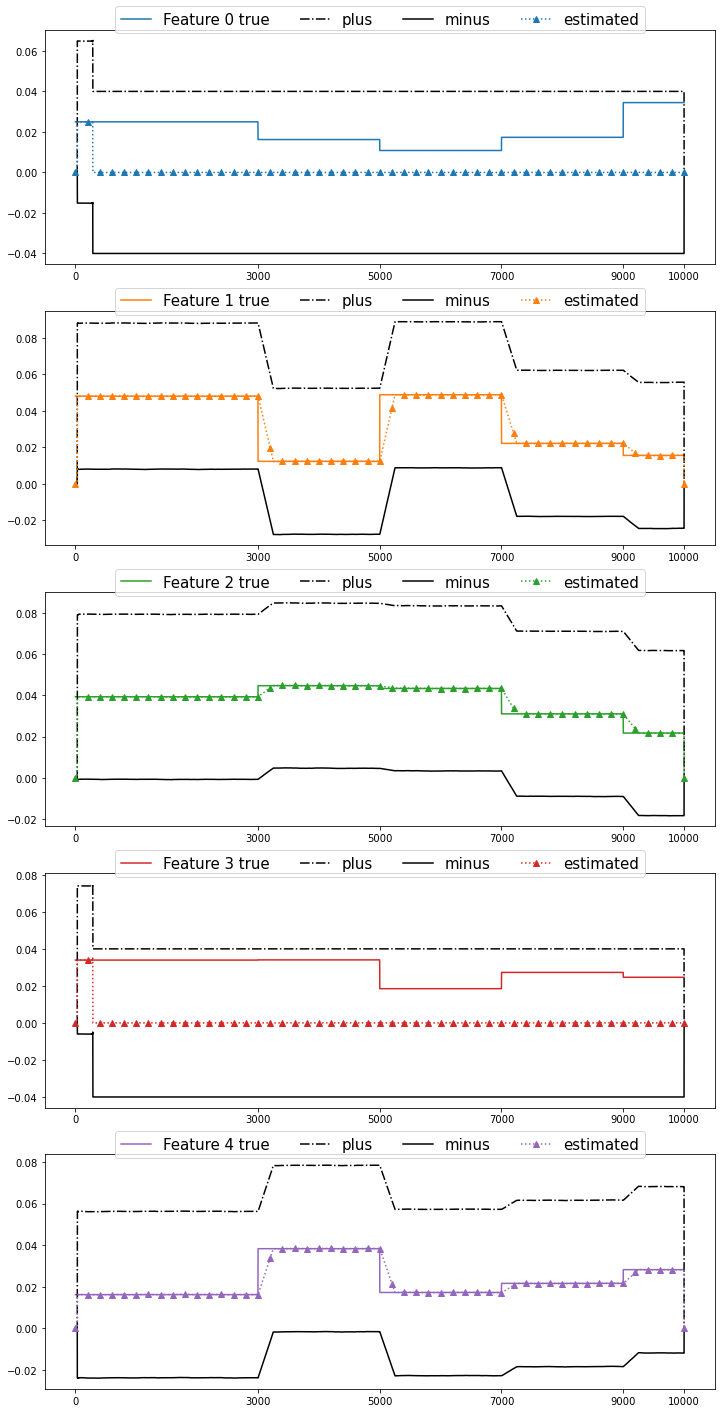

In [43]:
fig, axes = plt.subplots(new_contexts.shape[1], 1, figsize=(12, 5*new_contexts.shape[1]))

extraticks = full_cost_change_points

for feature, ax in enumerate(axes):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature} true", color=plt.cm.tab10(feature))
    ax.plot(p_alg1.costs_plus_bound[:, feature] , linestyle='-.', color='k', label='plus')
    ax.plot(p_alg1.costs_minus_bound[:, feature] , color='k', label='minus')
    ax.plot(
        p_alg1.c_hats[:, feature], marker='^', markevery=200, linestyle=':',
        color=plt.cm.tab10(feature), label='estimated'
    )

    lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

    ax.set_xticks(extraticks)
    
plt.show()

In [44]:
data_to_save = {
    'gain': {
        'Random': gain_random,
        r'$\epsilon$-greedy': gain_egreedy,
        'UCB1': gain_ucb,
        'LinUCB': gain_linucb,
        'PS-LinUCB': gain_pslinucb,
        'SimOOS': gain_simoos,
        'Algorithm1': gain_alg1,
        'Oracle': gain_alg1_oracle,
    },
    'reward': {
        'Random': reward_random,
        r'$\epsilon$-greedy': reward_egreedy,
        'UCB1': reward_ucb,
        'LinUCB': reward_linucb,
        'PS-LinUCB': reward_pslinucb,
        'SimOOS': reward_simoos,
        'Algorithm1': reward_alg1,
        'Oracle': reward_alg1_oracle,
    },
    'cost': {
        'Random': cost_random,
        r'$\epsilon$-greedy': cost_egreedy,
        'UCB1': cost_ucb,
        'LinUCB': cost_linucb,
        'PS-LinUCB': cost_pslinucb,
        'SimOOS': cost_simoos,
        'Algorithm1': cost_alg1,
        'Oracle': cost_alg1_oracle,
    },
    'reward_change_points': change_point_values,
    'cost_change_points': cost_change_points,
    'all_change_points': all_change_point_values,
}

In [45]:
with open('experiments/nursery/results/gains_feat_importance.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)

## Load data back

In [46]:
with open('experiments/nursery/results/gains_feat_importance.pickle', 'rb') as f:
    data_to_save = pickle.load(f)

In [47]:
gains = data_to_save['gain']

In [48]:
def plot_gains(gain_dict, reward_change_points=(), cost_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', 
                marker=mark, markevery=750, markersize=10,
                fillstyle='none', color=color,
                linewidth=3,
               )
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change points'
    )
    
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=20)
    plt.yticks(fontsize=20)
    
    ax.set_xlabel('Time step', fontsize=26)
    ax.set_ylabel('Cumulative gain', fontsize=26)
    
    plt.legend(prop={'size': 20});
    plt.show();

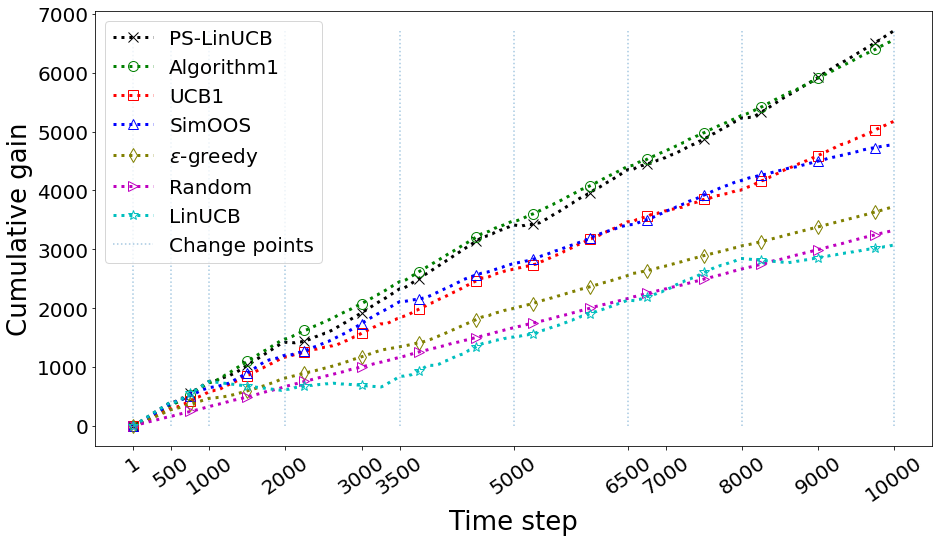

In [49]:
plot_gains(
    {
    'Random': gain_random,
    r'$\epsilon$-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
    },
    reward_change_points=change_point_values,
    cost_change_points=cost_change_points,
)


- markers bigger DONE
- labels bigger DONE
- legend bigger DONE
- thickness of curves bigger DONE
- save the data
- plot regret
- Think about figures
- Fixing the accuracy figure
- Write the text for experiment, add the figures